# MovieLens Recommender System
This project is a work in progress. Various techniques will be employed in the future to improve the results of this recommender system and provide accurate results.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
import operator as op
import warnings
from scipy import spatial
from sklearn import model_selection as ms

%matplotlib inline

warnings.filterwarnings('ignore')

movies_cols = ['movieId', 'title', 'genres']
movies_df = pd.read_csv(r'ml-1m/movies.dat', sep='::', names = movies_cols, usecols = [0, 1, 2], encoding="ISO-8859-1")

# Ignore timestamp column
ratings_cols = ['userId', 'movieId', 'rating']
ratings_df = pd.read_csv(r'ml-1m/ratings.dat', sep='::', names = ratings_cols, usecols = [0, 1, 2], encoding="ISO-8859-1")

In [2]:
movies_df.head()

,movieId,title,genres
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


In [3]:
ratings_df.head()

,userId,movieId,rating
0,1,1193,5
1,1,661,3
2,1,914,3
3,1,3408,4
4,1,2355,5


In [4]:
movie_ratings_df = pd.merge(movies_df, ratings_df);
movie_ratings_df.head()

,movieId,title,genres,userId,rating
0,1,Toy Story (1995),Animation|Children's|Comedy,1,5
1,1,Toy Story (1995),Animation|Children's|Comedy,6,4
2,1,Toy Story (1995),Animation|Children's|Comedy,8,4
3,1,Toy Story (1995),Animation|Children's|Comedy,9,5
4,1,Toy Story (1995),Animation|Children's|Comedy,10,5


In [5]:
moviesInfo = pd.DataFrame(movie_ratings_df.groupby('movieId')['rating'].mean())
moviesInfo['numRatings'] = movie_ratings_df.groupby('movieId')['rating'].count()
movieNormalizedNumRatings = pd.DataFrame(moviesInfo['rating'])
moviesInfo['ratingNormalized'] = movieNormalizedNumRatings.apply(lambda x: (x - np.min(x)) / (np.max(x) - np.min(x)))
moviesInfo.head()

,rating,numRatings,ratingNormalized
movieId,,,
1,4.146846,2077,0.786712
2,3.201141,701,0.550285
3,3.016736,478,0.504184
4,2.729412,170,0.432353
5,3.006757,296,0.501689


In [6]:
ratings_df['rating'].describe()

count    1.000209e+06
mean     3.581564e+00
std      1.117102e+00
min      1.000000e+00
25%      3.000000e+00
50%      4.000000e+00
75%      4.000000e+00
max      5.000000e+00
Name: rating, dtype: float64

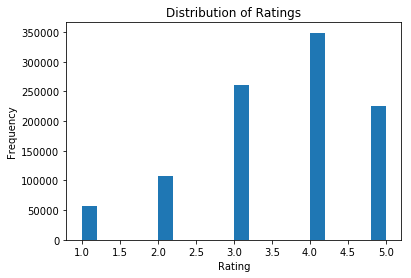

In [7]:
ratings_df.rating.plot.hist(bins=20)
plt.title("Distribution of Ratings")
plt.xlabel("Rating")
plt.ylabel("Frequency")

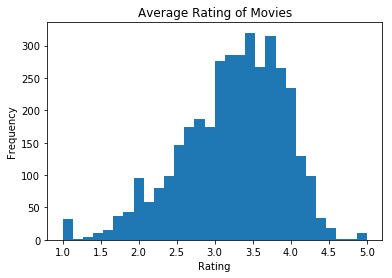

In [8]:
moviesInfo.rating.plot.hist(bins=30)
plt.title("Average Rating of Movies")
plt.xlabel("Rating")
plt.ylabel("Frequency")

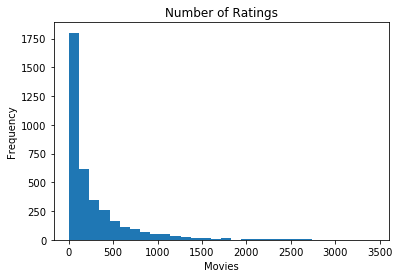

In [9]:
moviesInfo.numRatings.plot.hist(bins=30)
plt.title("Number of Ratings")
plt.xlabel("Movies")
plt.ylabel("Frequency")

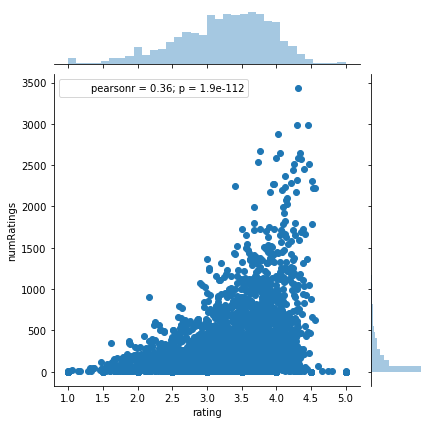

In [10]:
sb.jointplot(x='rating', y='numRatings', data=moviesInfo)

## Content-Based Filtering
Find K Nearest Neighbours (KNN) using genre and popularity

In [11]:
moviesInfoMinTreshold = moviesInfo.drop(moviesInfo[moviesInfo['numRatings'] < 100].index)
moviesInfoMinTreshold.head()

,rating,numRatings,ratingNormalized
movieId,,,
1,4.146846,2077,0.786712
2,3.201141,701,0.550285
3,3.016736,478,0.504184
4,2.729412,170,0.432353
5,3.006757,296,0.501689


In [12]:
genres = [
    "Action",
    "Adventure",
    "Animation",
    "Children's",
    "Comedy",
    "Crime",
    "Documentary",
    "Drama",
    "Fantasy",
    "Film-Noir",
    "Horror",
    "Musical",
    "Mystery",
    "Romance",
    "Sci-Fi",
    "Thriller",
    "War",
    "Western"
]

def getGenresList(movieGenres, totalGenresNum):
    genresList = np.zeros(len(genres), dtype=int)
    
    if not isinstance(movieGenres, list):
        return genresList
    
    for genre in movieGenres:
        if genre in genres:
            genresList[genres.index(genre)] = 1
    return genresList

movies_df.set_index(keys='movieId', inplace=True)
movieGenres = pd.DataFrame(movies_df['genres'].str.split("|"))

movieGenresDict = {}
totalGenresNum = len(genres)

for i in range(len(movieGenres)):
    if (i + 1 in movieGenres.index):
        movieGenresDict[i + 1] = getGenresList(movieGenres.get_value(i + 1, 'genres'), totalGenresNum)
        
def getMovieDistance(idMovie1, idMovie2):
    genresListMovie1 = movieGenresDict[idMovie1]
    genresListMovie2 = movieGenresDict[idMovie2]
    genreDistance = spatial.distance.cosine(genresListMovie1, genresListMovie2)
    ratingMovie1 = moviesInfoMinTreshold.get_value(idMovie1, 'ratingNormalized')
    ratingMovie2 = moviesInfoMinTreshold.get_value(idMovie2, 'ratingNormalized')
    ratingDistance = abs(ratingMovie1 - ratingMovie2)
    return (genreDistance + ratingDistance)

def getKNearestNeighbours(movieIdFocal, K):
    distances = []
    for movieId in movieGenresDict.keys():
        if (movieId != movieIdFocal and movieId in moviesInfoMinTreshold.index):
            dist = getMovieDistance(movieIdFocal, movieId)
            distances.append((movieId, dist))
    distances.sort(key=op.itemgetter(1))
    neighbours = []
    for x in range(K):
        neighbours.append(distances[x][0])
    return neighbours

def printKNearestNeighbours(movieIDFocal, K):
    neighbours = getKNearestNeighbours(movieIDFocal, K)
    neighbourInfo = []
    for neighbour in neighbours:
        neighbourInfo.append({'MovieId': neighbour,
                  'Title': movies_df.get_value(neighbour, 'title'),
                  'Average Rating': str(moviesInfoMinTreshold.get_value(neighbour, 'rating')),
                  'Genres': movies_df.get_value(neighbour, 'genres')})
        
    return pd.DataFrame(neighbourInfo).set_index(keys='MovieId')

In [13]:
toyStoryNeighbours = printKNearestNeighbours(1, 10)
toyStoryNeighbours

,Average Rating,Genres,Title
MovieId,,,
3114,4.21892744479,Animation|Children's|Comedy,Toy Story 2 (1999)
3751,3.87960872837,Animation|Children's|Comedy,Chicken Run (2000)
2355,3.854374633,Animation|Children's|Comedy,"Bug's Life, A (1998)"
2141,3.42821782178,Animation|Children's|Comedy,"American Tail, An (1986)"
2761,4.04747774481,Animation|Children's,"Iron Giant, The (1999)"
2078,3.81626506024,Animation|Children's|Comedy|Musical,"Jungle Book, The (1967)"
1023,3.98642533937,Animation|Children's,Winnie the Pooh and the Blustery Day (1968)
588,3.78830495929,Animation|Children's|Comedy|Musical,Aladdin (1992)
3429,4.33576642336,Animation|Comedy,Creature Comforts (1990)


In [14]:
starWarsNeighbours = printKNearestNeighbours(2628, 10)
starWarsNeighbours

,Average Rating,Genres,Title
MovieId,,,
2105,3.35567010309,Action|Adventure|Fantasy|Sci-Fi,Tron (1982)
1372,3.40959040959,Action|Adventure|Sci-Fi,Star Trek VI: The Undiscovered Country (1991)
329,3.37676767677,Action|Adventure|Sci-Fi,Star Trek: Generations (1994)
1375,3.35382955771,Action|Adventure|Sci-Fi,Star Trek III: The Search for Spock (1984)
2528,3.4696485623,Action|Adventure|Sci-Fi,Logan's Run (1976)
316,3.49014336918,Action|Adventure|Sci-Fi,Stargate (1994)
2193,3.49625935162,Action|Adventure|Fantasy,Willow (1988)
2640,3.53682487725,Action|Adventure|Sci-Fi,Superman (1978)
2173,3.56363636364,Adventure|Fantasy|Sci-Fi,"Navigator: A Mediaeval Odyssey, The (1988)"


## Item-Based Collaborative Filtering

In [15]:
userRatings_matrix = movie_ratings_df.pivot_table(index=['userId'],columns=['title'],values='rating')
userRatings_matrix.head()

title,"$1,000,000 Duck (1971)",'Night Mother (1986),'Til There Was You (1997),"'burbs, The (1989)",...And Justice for All (1979),1-900 (1994),10 Things I Hate About You (1999),101 Dalmatians (1961),101 Dalmatians (1996),12 Angry Men (1957),...,"Young Poisoner's Handbook, The (1995)",Young Sherlock Holmes (1985),Young and Innocent (1937),Your Friends and Neighbors (1998),Zachariah (1971),"Zed & Two Noughts, A (1985)",Zero Effect (1998),Zero Kelvin (Kjærlighetens kjøtere) (1995),Zeus and Roxanne (1997),eXistenZ (1999)
userId,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [16]:
corrMatrix = userRatings_matrix.corr(method='pearson', min_periods=100)
corrMatrix.head()

title,"$1,000,000 Duck (1971)",'Night Mother (1986),'Til There Was You (1997),"'burbs, The (1989)",...And Justice for All (1979),1-900 (1994),10 Things I Hate About You (1999),101 Dalmatians (1961),101 Dalmatians (1996),12 Angry Men (1957),...,"Young Poisoner's Handbook, The (1995)",Young Sherlock Holmes (1985),Young and Innocent (1937),Your Friends and Neighbors (1998),Zachariah (1971),"Zed & Two Noughts, A (1985)",Zero Effect (1998),Zero Kelvin (Kjærlighetens kjøtere) (1995),Zeus and Roxanne (1997),eXistenZ (1999)
title,,,,,,,,,,,,,,,,,,,,,
"$1,000,000 Duck (1971)",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
'Night Mother (1986),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
'Til There Was You (1997),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
"'burbs, The (1989)",NaN,NaN,NaN,1.0,NaN,NaN,NaN,0.088541,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...And Justice for All (1979),NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [17]:
# view the ratings given by a random user
ratingsUserX = userRatings_matrix.loc[632].dropna().sort_values(ascending=False)
ratingsUserX

title
Star Trek: First Contact (1996)                     5.0
Total Recall (1990)                                 5.0
Titanic (1997)                                      5.0
Terminator 2: Judgment Day (1991)                   5.0
Stargate (1994)                                     5.0
Contact (1997)                                      5.0
Star Trek VI: The Undiscovered Country (1991)       5.0
Arrival, The (1996)                                 4.0
Flight of the Navigator (1986)                      4.0
Forever Young (1992)                                4.0
Galaxy Quest (1999)                                 4.0
Body Snatchers (1993)                               4.0
Jurassic Park (1993)                                4.0
Matrix, The (1999)                                  4.0
Day the Earth Stood Still, The (1951)               4.0
Armageddon (1998)                                   4.0
Deep Impact (1998)                                  4.0
Star Trek: Generations (1994)             

In [18]:
# recommend movies to this random user
recommendedMovies = pd.Series()
for i in range(len(ratingsUserX.index)):
    movies = corrMatrix[ratingsUserX.index[i]].dropna()
    movies = movies.map(lambda x: x * ratingsUserX[i])
    recommendedMovies = recommendedMovies.append(movies)
    
recommendedMovies = recommendedMovies.groupby(recommendedMovies.index).sum()
recommendedMovies = recommendedMovies.drop(ratingsUserX.index)
recommendedMovies.sort_values(ascending = False, inplace = True)
recommendedMovies.head(20)

Lost in Space (1998)                          37.379086
Star Trek III: The Search for Spock (1984)    36.635240
Eraser (1996)                                 36.341965
Back to the Future Part II (1989)             34.969632
Star Trek V: The Final Frontier (1989)        34.277509
Twister (1996)                                34.001176
Lost World: Jurassic Park, The (1997)         33.808559
Superman III (1983)                           33.597083
Outbreak (1995)                               33.335293
Rock, The (1996)                              32.845315
Die Hard 2 (1990)                             32.676612
Mr. Mom (1983)                                32.571599
Enemy of the State (1998)                     32.463839
Net, The (1995)                               31.732298
Jewel of the Nile, The (1985)                 31.693351
Congo (1995)                                  31.668381
Cocoon (1985)                                 31.649533
Back to the Future Part III (1990)            31